<h1>Activation Functions</h1>

<h2>Hard Tanh</h2>
<p>Hard Tanhs are useful if we want to set all values over a threshold to one value, and all values below a threshold to another. For example, everything above 10 is just given the value 10, and everything below 0 is just given the value of 0.</p>

<centering>
<img src='images/hardtanh.png' style='width:50%; left:50%'/>
</centering>

<h2>Sigmoid</h2>
<p>Sigmoid functions are sensitive in the intermediate region between under- and over- saturation.</p>

<img src='images/sigmoid.png' style ='width:50%; background-color:white'/>

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim

In [150]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # Add extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

In [151]:
n_samples = t_u.shape[0] #Number of samples is equal to the length of the t_u tensor
n_val = int(0.2 * n_samples) #Number of data points which we want to reserve for validation

torch.manual_seed(1024)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([7, 2, 1, 0, 4, 6, 3, 5, 9]), tensor([ 8, 10]))

In [152]:
#Set aside for training
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

#Set aside for validation
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

In [153]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [154]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)


list(linear_model.parameters())
linear_model(t_un_val)

tensor([[1.8066],
        [2.9476]], grad_fn=<AddmmBackward0>)

In [155]:
def training_loop(n_epochs:int, optimizer:optim.Optimizer, model, loss_fn, t_u_train:torch.Tensor, t_u_val:torch.Tensor, 
                  t_c_train:torch.Tensor, t_c_val:torch.Tensor):
    """
    Perform a single iteration of the training loop using gradient descent.

    Args:
        n_epochs (int): The number of times the training loop is executed
        optimizer: Desired optimizer for use in training (e.g. Adam, SGD etc.)
        loss_fn (function): Function used to calculate loss produced by the model
    
    """

    for _ in range(n_epochs):

        t_p_train = model(t_u_train) #Calculate the predicted values of temperature in Celsius using the training data
        loss_train = loss_fn(t_p_train, t_c_train) #Calculate the loss on the training set

        t_p_val = model(t_u_val) #Predictions using validation data
        loss_val = loss_fn(t_p_val, t_c_val) #Loss on the validation set

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        
        if (_+1) % 1000 == 0 or (_+1) == 1:
            print(f'Epoch: {_+1}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

    

In [156]:
n_epochs = 3000

training_loop(n_epochs=n_epochs, 
              optimizer=optimizer, 
              model=linear_model, 
              loss_fn=nn.MSELoss(), 
              t_u_train = t_un_train, 
              t_u_val = t_un_val, 
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

linear_model.weight, linear_model.bias

Epoch: 1, Training Loss: 126.1531, Validation Loss: 171.7376
Epoch: 1000, Training Loss: 2.9642, Validation Loss: 7.3737
Epoch: 2000, Training Loss: 2.4484, Validation Loss: 5.7008
Epoch: 3000, Training Loss: 2.4376, Validation Loss: 5.4813


(Parameter containing:
 tensor([[5.2250]], requires_grad=True),
 Parameter containing:
 tensor([-16.4612], requires_grad=True))

<h1>Replacing Linear Model With Activation Function- Tanh</h1>

<h2>Layer 0</h2>
<p>We are building a sequential network with 3 layers- the input layer, which expects a single feature for each data point, and which then produces 13 features per sample- this is the <code>nn.Linear(1, 13)</code>. The weight matrix, <code>W</code>, has dimensions <code>(13,1)</code>, and the bias vector has dimension <code>(13)</code>, where we have:
<blockquote>
<code>y = Wx + b</code>
</blockquote>
</p>

<h2>Layer 1</h2>
<p><code>nn.Tanh()</code>- this is the activation function, and takes the 13 values of <code>y</code> produced by the first layer, and "squashes" them into the range <code>[-1, 1]</code></p>.

<h2>Layer 2</h2>
<p>This takes the output of the <code>tanh</code> function in layer 1, and outputs a single value from the 13 features given before. This means that the weight matrix, <code>W</code>, has dimensions <code>(1,13)</code>, and the final bias vector has dimensions <code>(1)</code>.</p>

In [157]:
seq_model = nn.Sequential(
    nn.Linear(1, 13), # (0) Dense layer- 13 features are generated from each datum's single feature
    nn.Tanh(), # (1) Activation Function- takes the tanh of the previous layer
    nn.Linear(13, 1) # (2) Dense Layer- all 13 features condensed back into one.
)

[param.shape for param in seq_model.parameters()] #Gives W and B shapes from first layer, then W and B shapes from third layer.
#Calling .backward() will populate all of the parameters with their gradients
#Then optimizer.step() updates all of these parameters accordingly using their gradients.

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [158]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [159]:
from collections import OrderedDict

In [160]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [161]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [162]:
optimizer = optim.SGD(
    seq_model.parameters(),
    lr = 1e-3
    )

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print('output', seq_model(t_un_val)) #Predictions for the Celsius temperatures in the validation set
print('answer', t_c_val) #Actual Celsius temperatures in the validation set
print('hidden', seq_model.hidden_linear.weight.grad) #Gradients in the hidden layer at the end of the training

Epoch: 1, Training Loss: 180.9725, Validation Loss: 245.3727
Epoch: 1000, Training Loss: 5.9882, Validation Loss: 6.9611
Epoch: 2000, Training Loss: 4.4919, Validation Loss: 4.6617
Epoch: 3000, Training Loss: 2.5622, Validation Loss: 2.0920
Epoch: 4000, Training Loss: 1.9648, Validation Loss: 1.5841
Epoch: 5000, Training Loss: 1.9034, Validation Loss: 1.7529
output tensor([[ 7.7904],
        [20.4519]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [21.]])
hidden tensor([[ 0.0077],
        [-0.0006],
        [ 0.0030],
        [-0.0151],
        [-0.0121],
        [ 0.0054],
        [ 0.0005],
        [-0.0004]])


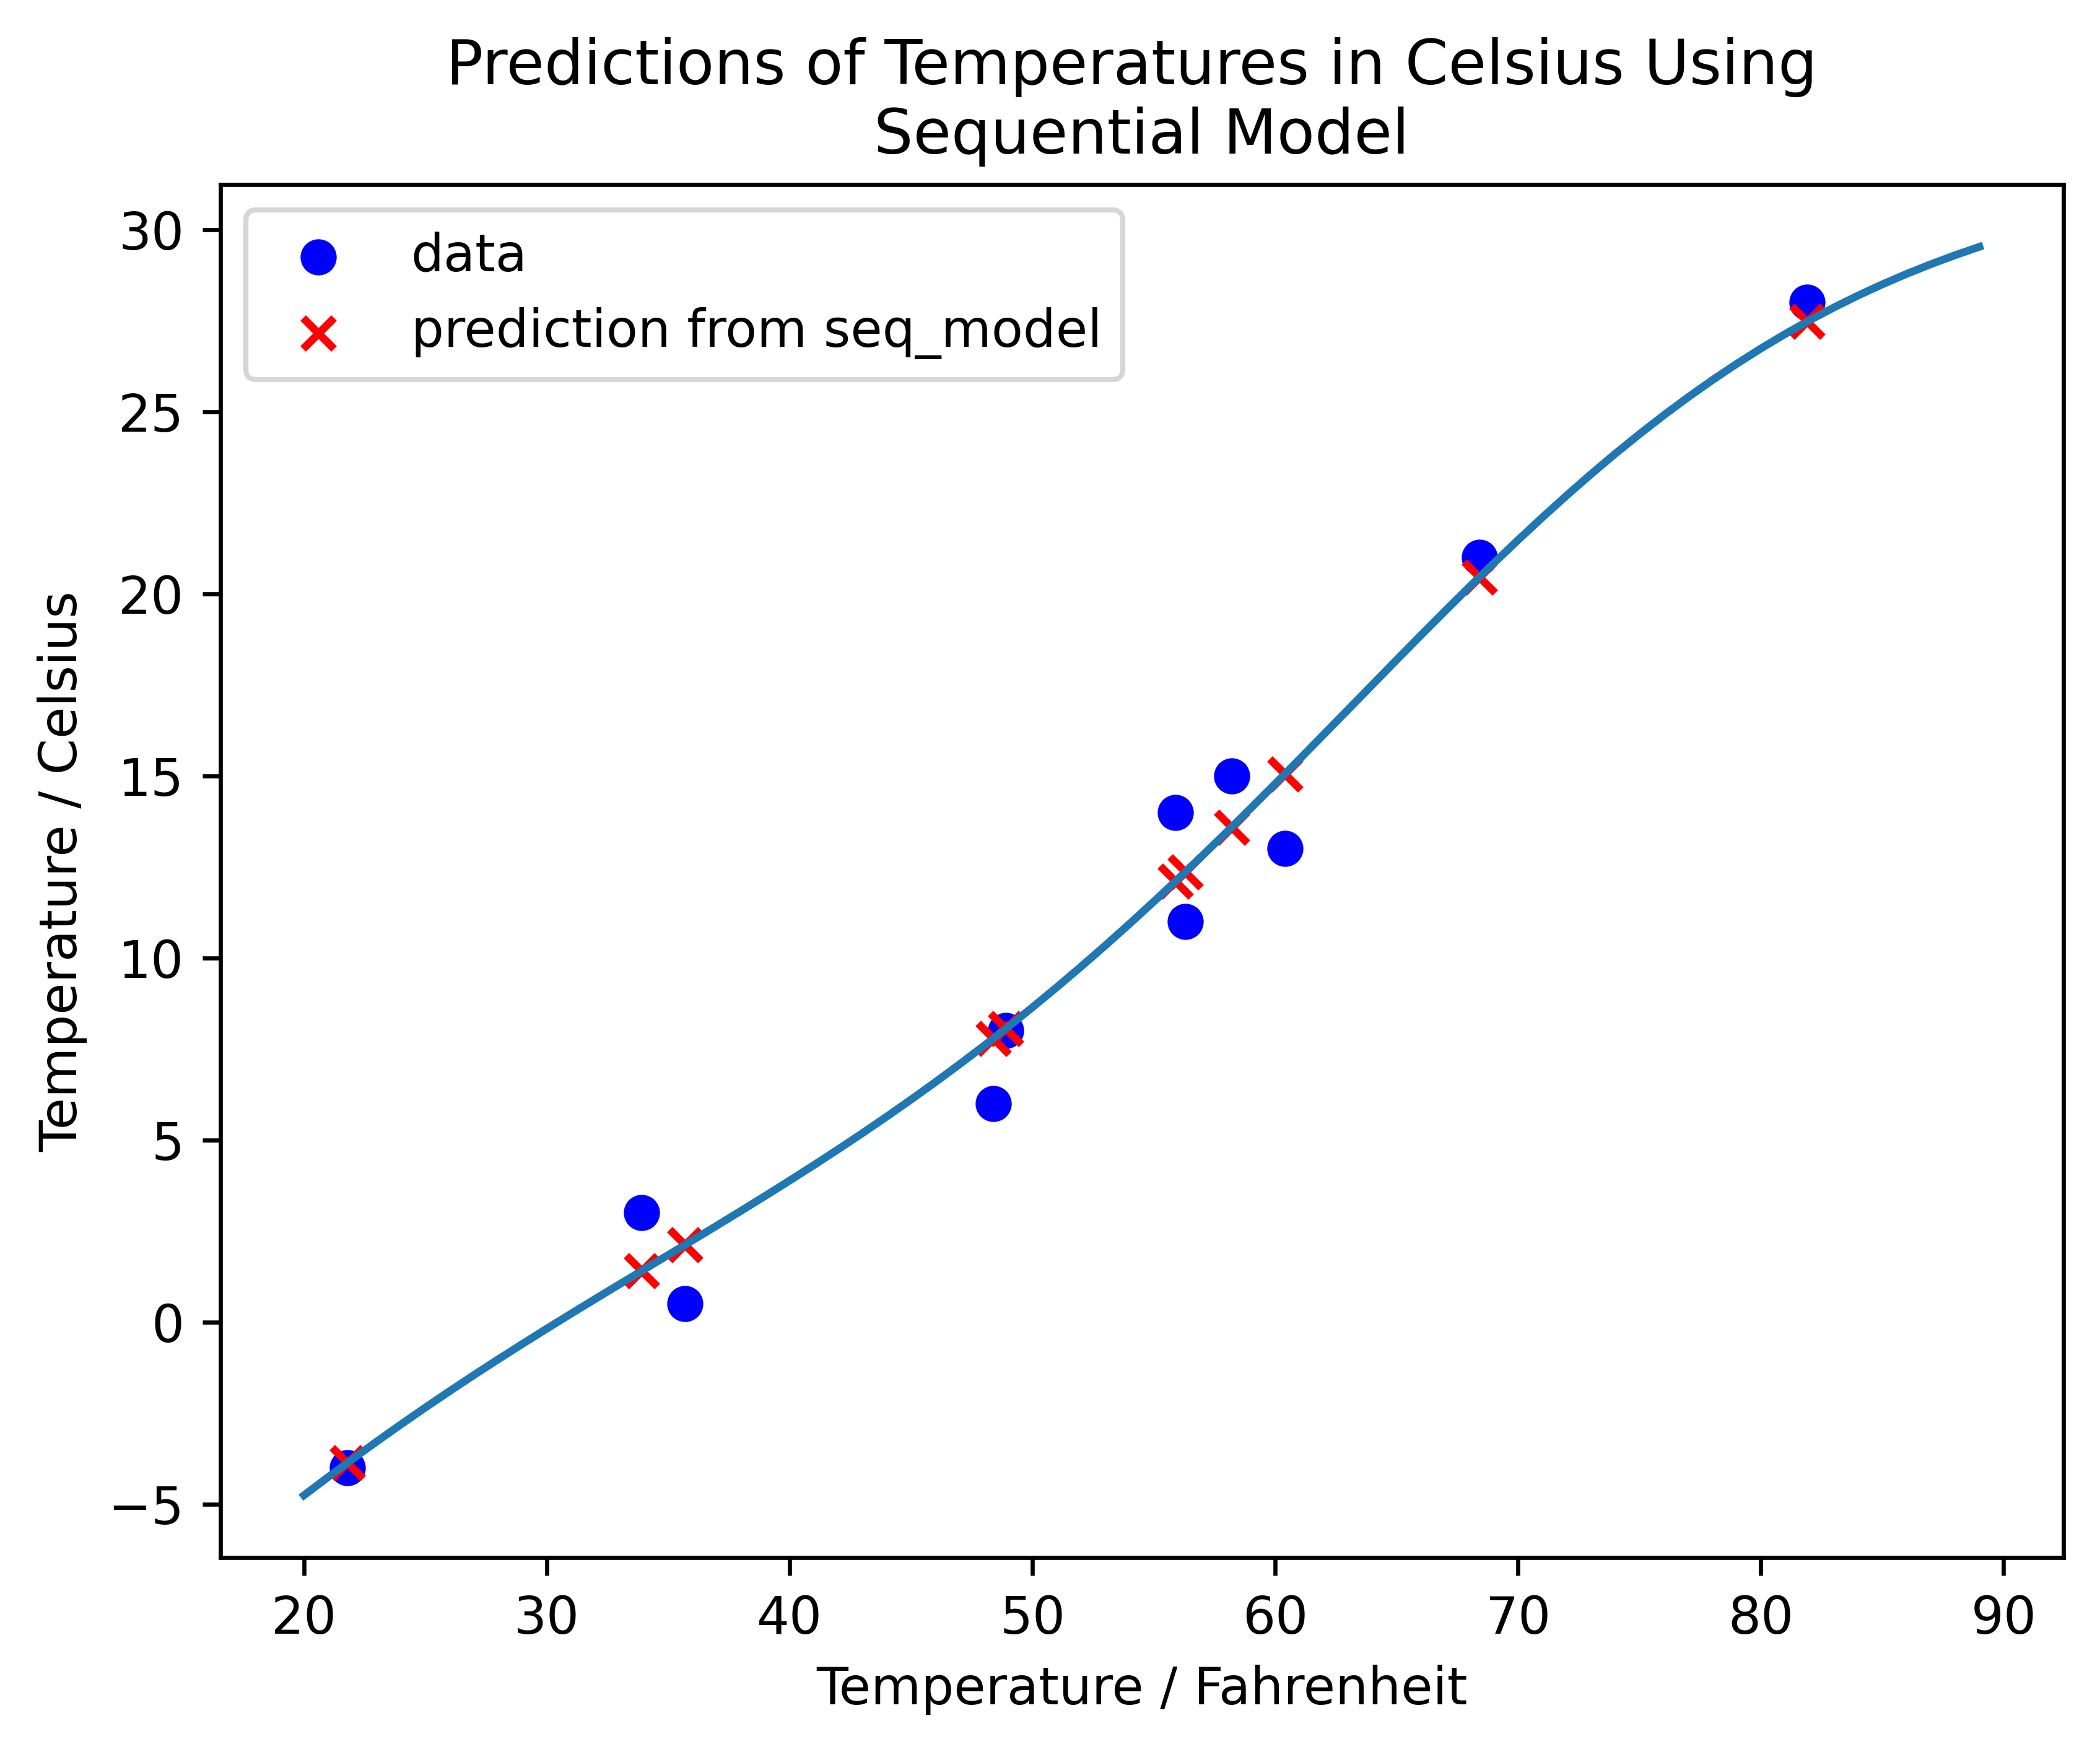

In [173]:
import matplotlib.pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.scatter(t_u.numpy(), t_c.numpy(), label='data', color='b') #Plot the actual data
plt.plot(t_range, seq_model(0.1* t_range).detach().numpy())
plt.scatter(t_u.numpy(), seq_model(0.1* t_u).detach().numpy(), marker='x', color='r', label='prediction from seq_model')

plt.xlabel('Temperature / Fahrenheit')
plt.ylabel('Temperature / Celsius')

plt.title('Predictions of Temperatures in Celsius Using \nSequential Model')

plt.legend()

Can see immediately that we have OVERFITTING. We know that the relationship between Fahrenheit and Celsius is LINEAR, and yet our sequential model has produced something definitively non-linear.